In [18]:
import numpy as np
import math
import os
import torch
import torch.nn as nn
from torch.optim import Adam, RMSprop
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn.functional as F
from collections import deque
from sklearn import metrics
from functools import wraps
from time import time
from pathlib import Path

n = 500
x_dim = 2
hiddens = [x_dim + 1, 32, 64, 1]
test_size = 0.2
valid_size = 0.125
batch_size = 10
seq_len = 10
l = 0.1
c_hiddens = [x_dim + 1, 32, 64, 1]
g_hidden_size = 64
g_num_layers = 2
d_hidden_size = 64
d_num_layers = 2
gan_epochs = 1000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

res_path = Path('../res')
log_dir = res_path / f'experiments_10pct_noise_adj_generation_balanced_decisions'
clf_path = log_dir / (f"c_model_" + ".pth")
gan_path = log_dir / (f"gan_model_" + str(gan_epochs) + "_" + str(g_hidden_size) + ".pth")
re_clf_path = log_dir / (f"dp_model-" + str(6)+ ".pth")
tsne_path = log_dir / (f"syn-tsne.png")

cuda:0


In [19]:
def tensor(x):
    return torch.FloatTensor(x)

def to_tensor(z, x, y=None):
    if torch.is_tensor(x):
        zx = torch.cat([z, x], dim=1)
    else:
        zx = np.concatenate([z, x], axis=1)
        zx = torch.FloatTensor(zx)
    if isinstance(y, np.ndarray):
        y = torch.FloatTensor(y)
        return zx, y
    return zx

class TrueModel(nn.Module):

    def __init__(self, hiddens, seed=0):
        super().__init__()
        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
        layers.pop()
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

    def forward(self, zx):
        return self.model(zx)

    def predict(self, z, x):
        zx = to_tensor(z, x)
        pred = self(zx)
        pred_y = pred.detach().round().cpu().numpy()
        return pred_y

    def fit(self, z, x, y, patience=10):
        zx, y = to_tensor(z, x, y)

        epoch, counter = 0, 0
        best_loss = float('inf')
        while True:
            pred = self(zx)
            loss = self.loss_fn(pred, y)

            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
            epoch += 1
            if loss.item() <= best_loss:
                torch.save(self.state_dict(), self.path)
                best_loss = loss.item()
                counter = 0
            else:
                counter += 1
                if counter == patience:
                    break
        print(f"TrueModel Fit Done in {epoch} epochs!")

    def sample(self, s, x, scale=0.8):
        sx = to_tensor(s, x)
        prob = self(sx)
        y = torch.bernoulli(prob * scale)
        return y.detach().cpu().numpy()

In [20]:
def demographic_parity(sensi, pred_y):

    s0 = sum(sensi.squeeze() == 0)
    s1 = sum(sensi.squeeze() == 1)
    y0 = sum(pred_y.squeeze() == 0)
    y1 = sum(pred_y.squeeze() == 1)
    y1_s0 = sum(pred_y[sensi.squeeze() == 0].squeeze() == 1) / s0
    y1_s1 = sum(pred_y[sensi.squeeze() == 1].squeeze() == 1) / s1
    print(f"#(S=0): {s0}, #(S=1): {s1}, #(y0): {y0}, #(y1): {y1}, P(y=1|s=0)={y1_s0:.3f}, P(y=1|s=1)={y1_s1:.3f}")
    return y1_s1 - y1_s0

In [21]:
def count_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time()
        result = func(*args, **kwargs)
        end_time = time()
        duration = end_time - start_time
        print(f"Time: {duration:5.2f}s")
        return result
    return wrapper

class Classifier(nn.Module):

    def __init__(self, hiddens, dropout_prob = 0.2):
        super().__init__()

        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=dropout_prob))
        layers.pop()
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)
        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

        self.dropout_prob = dropout_prob

    def get_params(self):
        params = []
        for param in self.parameters():
            params.append(param.detach().cpu().flatten().numpy())
        return np.hstack(params)

    def forward(self, s_mb, x_mb, num_samples = 10):
        pred = []

        for _ in range(num_samples):
            sx_mb = torch.cat([s_mb, x_mb], dim=1)
            output = self.model(sx_mb)
            pred.append(output.unsqueeze(0))  # Add the unsqueezed prediction
        return  torch.mean(torch.cat(pred, dim=0), dim=0)

    def predict(self, s_mb, x_mb):
        probs = self(s_mb, x_mb)
        pred_y = probs.detach().round().cpu().numpy()
        return pred_y

    def sample(self, s, x, scale=1.0):
        prob = self(s, x)
        y = torch.bernoulli(prob * scale)
        return y.detach().cpu().numpy()

    @count_time
    def fit(self, loader, valid_loader, save_path, device, max_epochs = 300, patience=20):
        epoch, counter = 0, 0
        best_loss = float('inf')

        while epoch < max_epochs:
            loss = 0.
            for s_mb, x_mb, y_mb in loader:
                s_mb = s_mb.to(device)
                x_mb = x_mb.to(device)
                y_mb = y_mb.to(device)

                batch_loss = 0.
                for i in range(x_mb.size(1)):
                    pred_y_mb = self(s_mb, x_mb[:, i])
                    batch_loss += self.loss_fn(pred_y_mb, y_mb[:, i])
                loss += batch_loss.item()

                self.optim.zero_grad()
                batch_loss.backward()
                self.optim.step()

            epoch += 1
            valid_loss = self.eval(valid_loader, device)
            if valid_loss <= best_loss:
                # torch.save(self.state_dict(), save_path)
                best_loss = valid_loss
                counter = 0
            else:
                counter += 1
                if counter == patience:
                    break
            
            if epoch == 1 or epoch % 100 == 0:
                print(f'{epoch:6.0f} | loss: {loss:6.4f}')
        print(f"Classifier Fit Done in {epoch} epochs!, Counter: {counter}")

    def eval(self, loader, device, verbose=False):
        loss = 0.
        for s_mb, x_mb, y_mb in loader:
            s_mb = s_mb.to(device)
            x_mb = x_mb.to(device)
            y_mb = y_mb.to(device)

            batch_loss = 0.
            for i in range(x_mb.size(1)):
                s_mb = s_mb.to(device)
                x_mb = x_mb.to(device)
                y_mb = y_mb.to(device)

                pred_y_mb = self(s_mb, x_mb[:, i].to(device))
                batch_loss += self.loss_fn(pred_y_mb, y_mb[:, i])
                loss += batch_loss.item()

                if verbose:
                    pred_y_mb = self.predict(s_mb, x_mb[:, i])
                    true_y_mb = y_mb[:, i].cpu().numpy()
                    s_mb_np = s_mb.cpu().numpy()

                    acc = metrics.accuracy_score(true_y_mb, pred_y_mb) * 100
                    fair = demographic_parity(s_mb_np, pred_y_mb)
                    print(f"Step: {i:6.0f}, ACC: {acc:6.2f}%, FAIR: {fair:6.2f}\n")
        return loss

In [22]:

def gen_initial_data(n, noise_factor = 1, seed = 0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    s0 = torch.bernoulli(torch.empty(n,1).uniform_(0,1)).numpy()
    x0 = np.random.randn(n, 1)*noise_factor + np.sin(s0)
    z0 = np.cos(x0) + np.random.randn(n, 1)*noise_factor + np.sin(s0)
    y = torch.bernoulli(torch.from_numpy(1 /(1+  np.exp(-x0-z0+1.7))))
    return torch.from_numpy(s0), to_tensor(x0, z0), y

def sequential_data(s0, x0, y0, seq_len, hiddens, l, noise_factor = 1, seed=0):
    n = s0.size()[0]
    model = TrueModel(hiddens, seed)
    sx = to_tensor(s0, x0)
    sx.requires_grad = True
    sx = sx.to(dtype=torch.float32)
    prob = model(sx)
    loss = nn.BCELoss()(prob, torch.ones_like(prob))
    loss.backward()
    x = x0
    y= y0
    prevx = x.numpy()
    prevy = y
    s0 = s0.numpy()
    nx = np.empty_like(s0)
    nz = np.empty_like(s0)
    ny = np.empty_like(s0)
    for i in range(1, seq_len):
        loss = nn.BCELoss()(prob, torch.ones_like(prob))
        delta_y = prevy*loss
        for j in range(n):
            nx[j] = np.random.randn()*noise_factor + np.sin(s0[j]) + l*(prevx[j][0] - prevy[j].item())
            nz[j] = np.cos(nx[j]) + np.random.randn()*noise_factor + np.sin(s0[j])  + l*(prevx[j][1] - prevy[j].item())
        ny = torch.bernoulli(torch.from_numpy(1 /(1+  np.exp(-nx-nz+1.7))))
        prevx = to_tensor(nx, nz)
        x = torch.cat((x, prevx),0)
        y = torch.cat((y, ny),0)
        prevx = prevx.numpy()
        prevy = ny
    # x = np.array(x, dtype=np.float32).reshape((n, seq_len, 2))
    #y = np.array(y, dtype=np.int32).reshape(n, seq_len, 1)
    return x, y
        

In [23]:
s0, x0, y0 = gen_initial_data(n, noise_factor=0.1, seed=0)
x, y = sequential_data(s0, x0, y0, seq_len, hiddens, l, noise_factor=0.1, seed=0)

In [24]:
sum(y==0)/len(y)

tensor([0.5056])

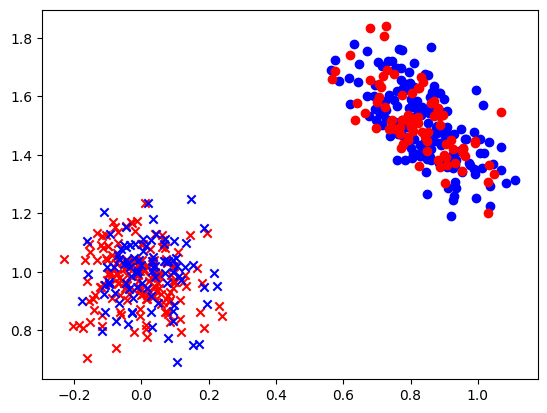

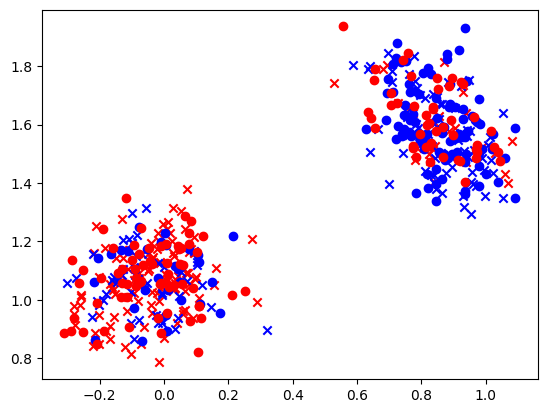

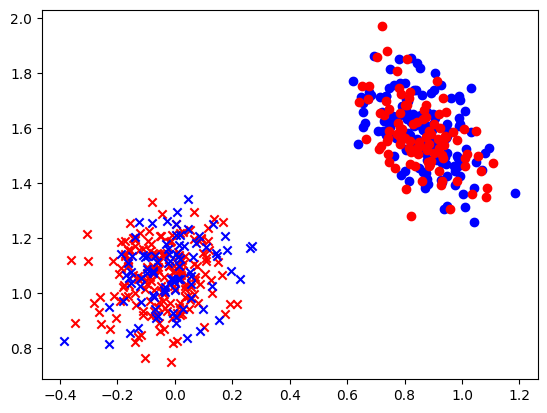

In [25]:
x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []
s_temp = np.array(s0)
for i in range(n):
    if y[i] == 1 and s_temp[i % n] == 1:
        x11.append(x[i][0])
        z11.append(x[i][1])
    elif y[i] == 1 and s_temp[i % n] == 0:
        x01.append(x[i][0])
        z01.append(x[i][1])
    elif y[i] == 0 and s_temp[i % n] == 1:
        x10.append(x[i][0])
        z10.append(x[i][1])
    else:
        x00.append(x[i][0])
        z00.append(x[i][1])


fig_start = plt.figure()
ax = fig_start.gca()

ax.scatter(x00, z00, marker = 'x', color = 'red')
ax.scatter(x11, z11, marker = 'o', color = 'blue')
ax.scatter(x01, z01, marker = 'x', color = 'blue')
ax.scatter(x10, z10, marker = 'o', color = 'red')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(3*n, 4*n):
    if y[i] == 1 and s_temp[i % 100] == 1:
        x11.append(x[i][0])
        z11.append(x[i][1])
    elif y[i] == 1 and s_temp[i % 100] == 0:
        x01.append(x[i][0])
        z01.append(x[i][1])
    elif y[i] == 0 and s_temp[i % 100] == 1:
        x10.append(x[i][0])
        z10.append(x[i][1])
    else:
        x00.append(x[i][0])
        z00.append(x[i][1])


fig_m = plt.figure()
axm = fig_m.gca()

axm.scatter(x00, z00, marker = 'x', color = 'red')
axm.scatter(x11, z11, marker = 'o', color = 'blue')
axm.scatter(x01, z01, marker = 'x', color = 'blue')
axm.scatter(x10, z10, marker = 'o', color = 'red')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(9*n, 10*n):
    if y[i] == 1 and s_temp[i % n] == 1:
        x11.append(x[i][0])
        z11.append(x[i][1])
    elif y[i] == 1 and s_temp[i % n] == 0:
        x01.append(x[i][0])
        z01.append(x[i][1])
    elif y[i] == 0 and s_temp[i % n] == 1:
        x10.append(x[i][0])
        z10.append(x[i][1])
    else:
        x00.append(x[i][0])
        z00.append(x[i][1])


fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
axf.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
axf.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
axf.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')


In [26]:
x_try = np.empty((seq_len, n, 2))
for i in range(seq_len):
    x_try[i] = x[i*n:(i+1)*n]
y_try = np.array(y, dtype=np.int32).reshape(seq_len, n, 1)
x_try[0,0,0].item()

1.0178762674331665

In [27]:
pairs = np.empty((0, 7))

for i in range(s0.shape[0]):
    temp_pair = np.empty((1, 7))
    temp_pair[0, 0] = s0[i].item()
    for j in range(seq_len - 1):
        for k in range(2):
            temp_pair[0, 1+k] = x_try[j, i, k].item()
        temp_pair[0, 1+x.shape[1]] = y_try[j, i].item()
        for k in range(2):
            temp_pair[0, 2+2+k] = x_try[j+1, i, k].item()
        temp_pair[0, 6] = y_try[j+1, i].item()
        pairs = np.vstack([pairs, temp_pair])

print(len(pairs))

4500


In [28]:
import pandas as pd

df = pd.DataFrame(pairs)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')


In [29]:

x = np.array(x, dtype=np.float32).reshape((n, seq_len, 2))
y = np.array(y, dtype=np.int32).reshape(n, seq_len, 1)
s0 = np.array(s0)
s_train, s_test, x_train, x_test, y_train, y_test = train_test_split(s0, x, y, test_size=test_size, random_state=10)
s_train, s_valid, x_train, x_valid, y_train, y_valid = train_test_split(s_train, x_train, y_train, test_size=valid_size, random_state=10)
print(x_train.shape)


(350, 10, 2)


In [30]:
class Generator(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.h0_linear = nn.Linear(in_size, hidden_size)
        self.rnn = nn.GRU(in_size + 3, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, in_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x0, noise, s0, clf):
        ss = torch.clone(s0)
        ss = ss.to(x0.device)
        s0 = torch.zeros(s0.size(0), 2).scatter_(1, s0.long(), torch.ones_like(s0))
        s0 = s0.to(x0.device)

        h0 = self.h0_linear(x0)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        yt = clf(ss, x0)
        
        xs, ys = [x0], [yt]
        for i in range(noise.size(1)):
            
            y_noise = torch.cat([s0, yt, noise[:, i]], dim=-1).unsqueeze(1)
            output, h0 = self.rnn(y_noise, h0)
            # xt = self.sigmoid(self.linear(output).squeeze())
            xt = self.linear(output).squeeze()
            yt = clf(ss, xt)

            xs.append(xt)
            ys.append(yt)

        xs = torch.stack(xs, dim=1)
        ys = torch.stack(ys, dim=1)
        return xs, ys, ys.round().detach()
    
class Discriminator(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.rnn = nn.GRU(in_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, hn = self.rnn(x)
        output = self.linear(output)
        output = self.sigmoid(output)
        return output

class DistributionDiscriminator(nn.Module):

    def __init__(self, hiddens):
        super().__init__()

        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.LeakyReLU(0.2))
        layers.pop()
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        output = self.model(x)
        return output

In [31]:
generator = Generator(x_dim, g_hidden_size, g_num_layers)
generator.to(device)
discriminator = Discriminator(x_dim, d_hidden_size, d_num_layers)
discriminator.to(device)
clf = Classifier(c_hiddens, dropout_prob=0.2)
clf.to(device)

Classifier(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): ReLU(inplace=True)
    (8): Sigmoid()
  )
  (loss_fn): BCELoss()
)

In [32]:
from torch.optim import Adam, RMSprop
from torch.utils.data import DataLoader, TensorDataset


def train_discriminator(clf, G, D, optim, loss_fn, xs, zs, ss):
    xs_fake, _, _ = G(xs[:, 0], zs, ss, clf)
    fake = D(xs_fake.detach())
    loss_fake = loss_fn(fake, torch.zeros_like(fake))

    real = D(xs)
    loss_real = loss_fn(real, torch.ones_like(real))

    loss = loss_fake + loss_real

    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss


def get_moment_loss(x_pred, x_true):
    m1 = torch.mean(torch.abs(x_pred.mean(dim=0) - x_true.mean(dim=0)))
    m2 = torch.mean(torch.abs(
        torch.sqrt(x_pred.var(dim=0, unbiased=False) + 1e-6) -
        torch.sqrt(x_true.var(dim=0, unbiased=False) + 1e-6)
    ))
    return m1 + m2


def train_generator(clf, G, D, optim, loss_fn, xs, zs, ss, gamma=100):
    xs_fake, _, _ = G(xs[:, 0], zs, ss, clf)
    fake = D(xs_fake)

    loss1 = loss_fn(fake, torch.ones_like(fake))
    loss2 = get_moment_loss(xs_fake, xs)
    loss = loss1 + gamma * loss2

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    return loss, loss2

@count_time
def train_gan(loader, clf, G, D, n_epochs, device):
    g_optim = Adam(G.parameters())
    d_optim = Adam(D.parameters())
    loss_fn = nn.BCELoss()
    hist_mmt = np.empty(0)

    for epoch in range(n_epochs):
        
        for i, (s_mb, x_mb, y_mb) in enumerate(loader, start=1):
            batch, seq, dim = x_mb.size()
            x_mb = x_mb.to(device)
            z_mb = torch.rand(batch, seq-1, dim).to(device)

            for _ in range(2):
                g_loss, mmt_loss = train_generator(clf, G, D, g_optim, loss_fn, x_mb, z_mb, s_mb)
                hist_mmt = np.append(hist_mmt, float(mmt_loss))

            for _ in range(1):
                d_loss = train_discriminator(clf, G, D, d_optim, loss_fn, x_mb, z_mb, s_mb)

            step = epoch * len(loader) + i
            if step % 1000 == 0:
                print(f'Epoch: {epoch: 6.0f} | step: {step:6.0f} | d_loss: {d_loss:6.4f} | g_loss: {g_loss: 6.4f} | mmt_loss: {mmt_loss:6.4f}')

    hist_mmt = np.asarray(hist_mmt)
    plt.plot(np.arange(0, len(hist_mmt), 1), hist_mmt)
    # plt.plot(np.arange(0, len(hist_mmt) + 1, 1), np.arange(0, len(hist_mmt) + 1, 1))

def generate_dataset_from_gan(loader, clf, G, device, extra_seq=0):
    gen_s, gen_x, gen_y = [], [], []

    batch_size = None
    for s_mb, x_mb, y_mb in loader:
        batch, seq_len, x_dim = x_mb.shape
        if batch_size is None:
            batch_size = batch

        x_mb = x_mb.to(device)
        z_mb = torch.randn(batch, seq_len + extra_seq - 1, x_dim).to(device)

        gen_x_mb, _, gen_y_mb = G(x_mb[:, 0], z_mb, s_mb, clf)
        
        gen_s.append(s_mb)
        gen_x.append(gen_x_mb)
        gen_y.append(gen_y_mb)

    gen_s = torch.cat(gen_s, dim=0).detach().cpu().numpy()
    gen_x = torch.cat(gen_x, dim=0).detach().cpu().numpy()
    gen_y = torch.cat(gen_y, dim=0).detach().cpu().numpy()

    gen_data = TensorDataset(tensor(gen_s), tensor(gen_x), tensor(gen_y))
    gen_loader = DataLoader(gen_data, batch_size=batch_size, shuffle=False)

    return gen_loader, gen_s, gen_x, gen_y

In [33]:
train_data = TensorDataset(tensor(s_train), tensor(x_train), tensor(y_train))
valid_data = TensorDataset(tensor(s_valid), tensor(x_valid),tensor(y_valid))
test_data = TensorDataset(tensor(s_test), tensor(x_test), tensor(y_test))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [34]:
# clf.cuda()
if clf_path.exists():
    clf.load_state_dict(torch.load(clf_path, map_location=device))
else:
    clf.fit(train_loader, valid_loader, clf_path, device)
    torch.save(clf.state_dict(), clf_path)

     1 | loss: 238.6572
Classifier Fit Done in 28 epochs!, Counter: 20
Time: 66.28s


In [35]:
clf.eval(test_loader, device)

37.12904340028763

Epoch:     28 | step:   1000 | d_loss: 0.3907 | g_loss:  24.9449 | mmt_loss: 0.2092
Epoch:     57 | step:   2000 | d_loss: 0.3771 | g_loss:  43.1508 | mmt_loss: 0.3989
Epoch:     85 | step:   3000 | d_loss: 0.5614 | g_loss:  19.9339 | mmt_loss: 0.1516
Epoch:    114 | step:   4000 | d_loss: 0.4553 | g_loss:  19.9099 | mmt_loss: 0.1678
Epoch:    142 | step:   5000 | d_loss: 0.4983 | g_loss:  21.2783 | mmt_loss: 0.1745
Epoch:    171 | step:   6000 | d_loss: 0.5173 | g_loss:  15.9004 | mmt_loss: 0.1242
Epoch:    199 | step:   7000 | d_loss: 0.3784 | g_loss:  10.6112 | mmt_loss: 0.0708
Epoch:    228 | step:   8000 | d_loss: 0.5694 | g_loss:  17.6203 | mmt_loss: 0.1314
Epoch:    257 | step:   9000 | d_loss: 0.4166 | g_loss:  20.8710 | mmt_loss: 0.1696
Epoch:    285 | step:  10000 | d_loss: 0.6281 | g_loss:  21.5209 | mmt_loss: 0.1681
Epoch:    314 | step:  11000 | d_loss: 0.4297 | g_loss:  11.0094 | mmt_loss: 0.0657
Epoch:    342 | step:  12000 | d_loss: 0.5365 | g_loss:  15.7536 | mmt_loss:

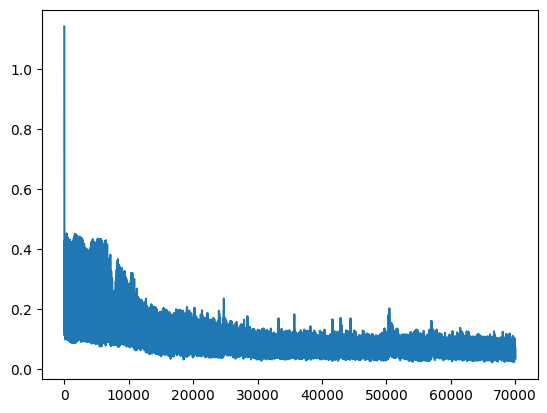

In [36]:
if gan_path.exists():
    generator.load_state_dict(torch.load(gan_path, map_location=device))
else:
    train_gan(train_loader, clf, generator, discriminator, gan_epochs, device)
    torch.save(generator.state_dict(), gan_path)

In [37]:
gen_train_loader, gen_train_s, gen_train_x, gen_train_y = generate_dataset_from_gan(train_loader, clf, generator, device)
gen_valid_loader, gen_valid_s, gen_valid_x, gen_valid_y = generate_dataset_from_gan(valid_loader, clf, generator, device)
gen_test_loader, gen_test_s, gen_test_x, gen_test_y = generate_dataset_from_gan(test_loader, clf, generator, device)

In [38]:
x_vars = gen_train_x[:,:,0]
z_vars = gen_train_x[:,:,1]
y_vars = gen_train_y[:, :, 0]

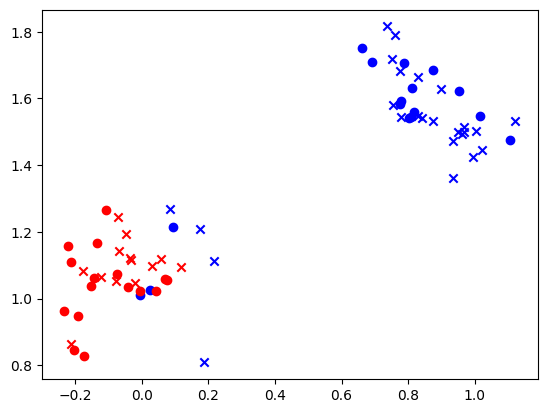

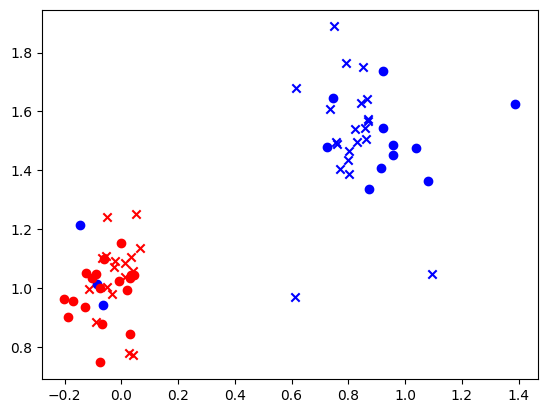

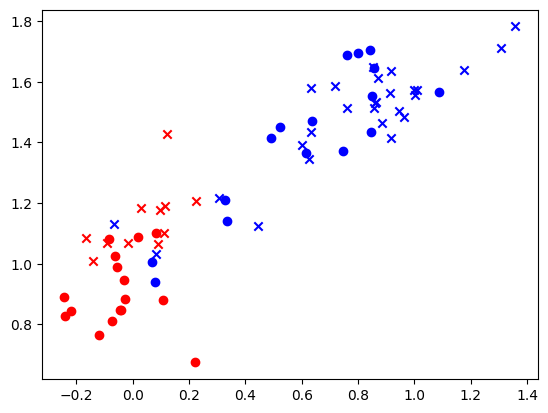

In [39]:
x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(70):
    if gen_train_y[i][0][0] == 1 and gen_train_s[i][0] == 1:
        x11.append(x_vars[i][0])
        z11.append(z_vars[i][0])
    elif gen_train_y[i][0][0] == 1 and gen_train_s[i][0] == 0:
        x01.append(x_vars[i][0])
        z01.append(z_vars[i][0])
    elif gen_train_y[i][0][0] == 0 and gen_train_s[i][0] == 1:
        x10.append(x_vars[i][0])
        z10.append(z_vars[i][0])
    else:
        x00.append(x_vars[i][0])
        z00.append(z_vars[i][0])

fig_start = plt.figure()
ax = fig_start.gca()

ax.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
ax.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
ax.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
ax.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(70):
    if gen_train_y[i][3][0] == 1 and gen_train_s[i][0] == 1:
        x11.append(x_vars[i][3])
        z11.append(z_vars[i][3])
    elif gen_train_y[i][3][0] == 1 and gen_train_s[i][0] == 0:
        x01.append(x_vars[i][3])
        z01.append(z_vars[i][3])
    elif gen_train_y[i][3][0] == 0 and gen_train_s[i][0] == 1:
        x10.append(x_vars[i][3])
        z10.append(z_vars[i][3])
    else:
        x00.append(x_vars[i][3])
        z00.append(z_vars[i][3])

fig_m = plt.figure()
axm = fig_m.gca()

axm.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
axm.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
axm.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
axm.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(70):
    if gen_train_y[i][9][0] == 1 and gen_train_s[i][0] == 1:
        x11.append(x_vars[i][9])
        z11.append(z_vars[i][9])
    elif gen_train_y[i][9][0] == 1 and gen_train_s[i][0] == 0:
        x01.append(x_vars[i][9])
        z01.append(z_vars[i][9])
    elif gen_train_y[i][9][0] == 0 and gen_train_s[i][0] == 1:
        x10.append(x_vars[i][9])
        z10.append(z_vars[i][9])
    else:
        x00.append(x_vars[i][9])
        z00.append(z_vars[i][9])

fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
axf.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
axf.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
axf.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')

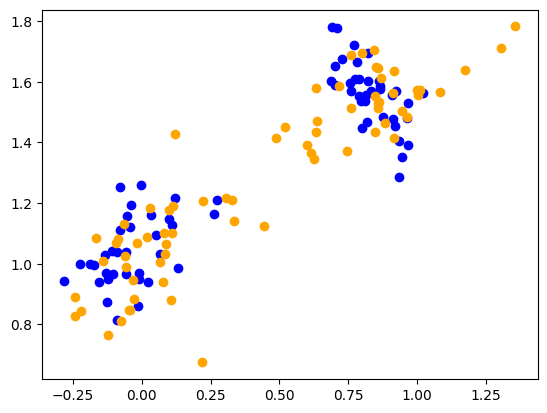

In [40]:
x_real_f = []
z_real_f = []

for i in range(70):
    x_real_f.append(x_train[i][9][0])
    z_real_f.append(x_train[i][9][1])

x_gan_f = []
z_gan_f = []
for i in range(70):
    x_gan_f.append(x_vars[i][9])
    z_gan_f.append(z_vars[i][9])

fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x_real_f, z_real_f, color = 'blue')
axf.scatter(x_gan_f, z_gan_f, color = 'orange')

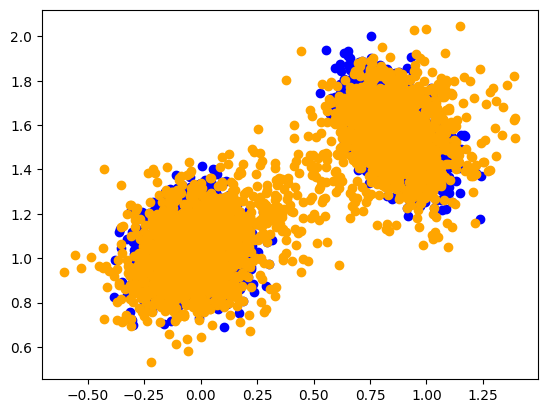

In [41]:
x_real_f = x_train[:, :, 0]
z_real_f = x_train[:, :, 1]

fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x_real_f, z_real_f, color = 'blue')
axf.scatter(x_vars, z_vars, color = 'orange')

In [42]:
# separate generated training data into sequential step-wise pairs i.e. t0-t1, t1-t2, t2-t3, etc.
pairs = np.empty((0, 7))

for i in range(gen_train_x.shape[0]):
    temp_pair = np.empty((1, 5 + 2*(gen_train_x.shape[2] - 1)))
    temp_pair[0, 0] = gen_train_s[i][0]
    for j in range(gen_train_x.shape[1] - 1):
        for k in range(gen_train_x[0][0].shape[0]):
            temp_pair[0, 1+k] = gen_train_x[i, j, k]
        temp_pair[0, 1+gen_train_x.shape[2]] = gen_train_y[i, j][0]
        for k in range(gen_train_x[0][0].shape[0]):
            temp_pair[0, 2 + gen_train_x.shape[2] + k] = gen_train_x[i, j+1, k]
        temp_pair[0, 5 + 2*(gen_train_x.shape[2] - 1) - 1] = gen_train_y[i, j+1][0]
        pairs = np.vstack([pairs, temp_pair])

print(len(pairs))

for i in range(gen_valid_x.shape[0]):
    temp_pair = np.empty((1, 5 + 2*(gen_valid_x.shape[2] - 1)))
    temp_pair[0, 0] = gen_valid_s[i][0]
    for j in range(gen_valid_x.shape[1] - 1):
        for k in range(gen_valid_x[0][0].shape[0]):
            temp_pair[0, 1+k] = gen_valid_x[i, j, k]
        temp_pair[0, 1+gen_valid_x.shape[2]] = gen_valid_y[i, j][0]
        for k in range(gen_valid_x[0][0].shape[0]):
            temp_pair[0, 2 + gen_valid_x.shape[2] + k] = gen_valid_x[i, j+1, k]
        temp_pair[0, 5 + 2*(gen_valid_x.shape[2] - 1) - 1] = gen_valid_y[i, j+1][0]
        pairs = np.vstack([pairs, temp_pair])

print(len(pairs))

for i in range(gen_test_x.shape[0]):
    temp_pair = np.empty((1, 5 + 2*(gen_test_x.shape[2] - 1)))
    temp_pair[0, 0] = gen_test_s[i][0]
    for j in range(gen_test_x.shape[1] - 1):
        for k in range(gen_test_x[0][0].shape[0]):
            temp_pair[0, 1+k] = gen_test_x[i, j, k]
        temp_pair[0, 1+gen_test_x.shape[2]] = gen_test_y[i, j][0]
        for k in range(gen_test_x[0][0].shape[0]):
            temp_pair[0, 2 + gen_test_x.shape[2] + k] = gen_test_x[i, j+1, k]
        temp_pair[0, 5 + 2*(gen_test_x.shape[2] - 1) - 1] = gen_test_y[i, j+1][0]
        pairs = np.vstack([pairs, temp_pair])

print(len(pairs))


3150
3600
4500


In [43]:

import pandas as pd

df = pd.DataFrame(pairs)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')


In [205]:
import os
import pandas as pd
from datasets.toy import ToySCM
from models.vaca import VACA
import utils.args_parser  as argtools
from data_modules.het_scm import HeterogeneousSCMDataModule

scm = ToySCM(None, 'train', len(pairs))
model_file = os.path.join('_params', 'model_vaca.yaml')
trainer_file = os.path.join('_params', 'trainer.yaml')

cfg = argtools.parse_args(model_file)
cfg.update(argtools.parse_args(trainer_file))

cfg['dataset'] = {
    'name': 'toy',
    'params1': {},
    'params2': {}
}

cfg['dataset']['params1']['batch_size'] = batch_size
cfg['dataset']['params1']['num_samples_tr'] = len(pairs)
cfg['dataset']['params1']['num_workers'] = 0
cfg['dataset']['params1']['equations_type'] = 'non-linear'
cfg['dataset']['params1']['normalize'] = 'lik'
cfg['dataset']['params1']['lambda_'] = 0.05
cfg['dataset']['params1']['data_dir'] = '../Data'
cfg['dataset']['params1']['device'] = device

dataset_params = cfg['dataset']['params1']
data_module = HeterogeneousSCMDataModule(**dataset_params)

data_module.train_dataset._create_data()
data_module.valid_dataset._create_data()
data_module.test_dataset._create_data()
data_module.prepare_data()
data_module.train_dataloader()
data_module.test_dataloader()
data_module.val_dataloader()


cfg['model']['params']['is_heterogeneous'] = scm.is_heterogeneous
cfg['model']['params']['likelihood_x'] = scm.likelihood_list

cfg['model']['params']['num_nodes'] = scm.num_nodes
cfg['model']['params']['edge_dim'] = scm.edge_dimension

model_params = cfg['model']['params']

model_vaca = VACA(**model_params)
model_vaca.set_random_train_sampler(data_module.get_random_train_sampler())

model_vaca.set_optim_params(optim_params=cfg['optimizer'],
                            sched_params=cfg['scheduler'])

Train Dataloader implemented
Test Dataloader implemented
Valid Dataloader implemented


In [206]:
from models._evaluator import MyEvaluator

evaluator = MyEvaluator(model=model_vaca,
                        intervention_list=data_module.train_dataset.get_intervention_list(),
                        scaler=data_module.scaler
                        )
model_vaca.set_my_evaluator(evaluator=evaluator)

assert evaluator is not None
is_training = 1
del cfg['trainer']['progress_bar_refresh_rate']
del cfg['trainer']['flush_logs_every_n_steps']
del cfg['trainer']['terminate_on_nan']
del cfg['trainer']['auto_select_gpus']
del cfg['trainer']['weights_summary']
cfg['trainer']['enable_model_summary'] = False
del cfg['trainer']['gpus']
del cfg['trainer']['track_grad_norm']


In [207]:
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl

yaml_file = ''
if yaml_file == '':
        save_dir = argtools.mkdir(os.path.join(cfg['root_dir'],
                                               argtools.get_experiment_folder(cfg),
                                               str(cfg['seed'])))
else:
        save_dir = os.path.join(yaml_file.split('/')[:-1])
print(f'Save dir: {save_dir}')
# trainer = pl.Trainer(**cfg['model'])
logger = TensorBoardLogger(save_dir=save_dir, name='logs', default_hp_metric=False)
out = logger.log_hyperparams(argtools.flatten_cfg(cfg))

save_dir_ckpt = argtools.mkdir(os.path.join(save_dir, 'ckpt'))
ckpt_file = argtools.newest(save_dir_ckpt)
callbacks = []
if is_training == 1:
    
    checkpoint = ModelCheckpoint(monitor=model_vaca.monitor(),
                                     mode=model_vaca.monitor_mode(),
                                     save_top_k=1,
                                     save_last=True,
                                     filename='checkpoint-{epoch:02d}',
                                     dirpath=save_dir_ckpt)

    callbacks = [checkpoint]

    if cfg['early_stopping']:
            early_stopping = EarlyStopping(model_vaca.monitor(), mode=model_vaca.monitor_mode(), min_delta=0.0,
                                           patience=50)
            callbacks.append(early_stopping)

    if ckpt_file is not None:
            print(f'Loading model training: {ckpt_file}')
            trainer = pl.Trainer(logger=logger, callbacks=callbacks, **cfg['trainer'], devices='auto', accelerator='cpu')
    else:

            trainer = pl.Trainer(logger=logger, callbacks=callbacks, **cfg['trainer'], devices='auto', accelerator='cpu')

    trainer.fit(model=model_vaca, datamodule=data_module)
    trainer.validate(ckpt_path=ckpt_file, dataloaders=data_module.val_dataloader())
    trainer.test(ckpt_path=ckpt_file, dataloaders=data_module.test_dataloader())
    argtools.save_yaml(cfg, file_path=os.path.join(save_dir, 'hparams_full.yaml'))
    
else:
        model_vaca = VACA.load_from_checkpoint(ckpt_file, **model_params)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Save dir: exper_test/toy_/vaca/dgnn_elbo_8_8_16_4_normal_0.0_0.2_0.0_0.0_0_True_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_7_21/adam/0.005_0.9_0.999_1.2e-06_exp_lr_0.99/9
Loading model training: exper_test/toy_/vaca/dgnn_elbo_8_8_16_4_normal_0.0_0.2_0.0_0.0_0_True_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_7_21/adam/0.005_0.9_0.999_1.2e-06_exp_lr_0.99/9/ckpt/last-v10.ckpt


/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/.venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/SimLoan/VACA/exper_test/toy_/vaca/dgnn_elbo_8_8_16_4_normal_0.0_0.2_0.0_0.0_0_True_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_7_21/adam/0.005_0.9_0.999_1.2e-06_exp_lr_0.99/9/ckpt exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]Valid Dataloader implemented
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/.venv/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 70. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Train Dataloader implemented                                               
Epoch 399: 100%|██████████| 315/315 [00:19<00:00, 15.95it/s, v_num=28, train_objective=-5.81, train_log_prob_x=-3.35, train_kl_z=2.460, valid_elbo=-3.90, valid_log_prob_x=-1.88, valid_kl_z=2.030, valid_iwae_100=-3.84] 

Restoring states from the checkpoint path at exper_test/toy_/vaca/dgnn_elbo_8_8_16_4_normal_0.0_0.2_0.0_0.0_0_True_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_7_21/adam/0.005_0.9_0.999_1.2e-06_exp_lr_0.99/9/ckpt/last-v10.ckpt
Loaded model weights from the checkpoint at exper_test/toy_/vaca/dgnn_elbo_8_8_16_4_normal_0.0_0.2_0.0_0.0_0_True_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_7_21/adam/0.005_0.9_0.999_1.2e-06_exp_lr_0.99/9/ckpt/last-v10.ckpt



Valid Dataloader implemented
Validation DataLoader 0: 100%|██████████| 45/45 [00:11<00:00,  4.04it/s]

Restoring states from the checkpoint path at exper_test/toy_/vaca/dgnn_elbo_8_8_16_4_normal_0.0_0.2_0.0_0.0_0_True_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_7_21/adam/0.005_0.9_0.999_1.2e-06_exp_lr_0.99/9/ckpt/last-v10.ckpt
Loaded model weights from the checkpoint at exper_test/toy_/vaca/dgnn_elbo_8_8_16_4_normal_0.0_0.2_0.0_0.0_0_True_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_7_21/adam/0.005_0.9_0.999_1.2e-06_exp_lr_0.99/9/ckpt/last-v10.ckpt



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       valid_elbo           -11.552399635314941
     valid_iwae_100          -10.984130859375
       valid_kl_z            4.200109004974365
    valid_log_prob_x        -7.352290630340576
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test Dataloader implemented
Testing DataLoader 0: 100%|██████████| 90/90 [00:05<00:00, 16.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_elbo   

In [217]:

evaluator.set_model(model_vaca)
model_vaca.set_my_evaluator(evaluator=evaluator)


In [218]:
model_parameters = filter(lambda p: p.requires_grad, model_vaca.parameters())
params = int(sum([np.prod(p.size()) for p in model_parameters]))
model_vaca.eval()
model_vaca.freeze()

In [219]:
bs = data_module.batch_size
data_module.batch_size = 1
x_I = {'z1': 0.1}
data_loader = data_module.test_dataloader()
data_loader.dataset.set_intervention(x_I, is_noise=True)
data_loader = data_module.test_dataloader()

it = iter(data_loader)
batch = next(it)
batch = next(it)

print(batch.x_i)

Test Dataloader implemented
Test Dataloader implemented


tensor([[ 0.0000],
        [-0.7367],
        [-0.5554],
        [ 0.0000],
        [-1.0843],
        [-1.3825],
        [ 0.0000]])


In [220]:
def gt_inter(dataloader, batch, intervention_dict):
    inter_flag = "pre"
    x_factual = {}
    parents_dict = {}
    x = batch.x.detach().clone()
    nodes_list, parents_list = dataloader.dataset.get_topological_nodes_pa()
    for obs_i, pa_i in zip(nodes_list, parents_list):
        obs_name = dataloader.dataset.nodes_list[obs_i]
        x_factual[obs_name] = x[obs_i]
        if obs_name in intervention_dict:
            inter_flag = "post"
            if dataloader.dataset.I_noise is True:
                x_factual[obs_name] = intervention_dict[obs_name] + x[obs_i]
                x[obs_i] = intervention_dict[obs_name] + x[obs_i]
            else:
                x_factual[obs_name] = intervention_dict[obs_name]
                x[obs_i] = intervention_dict[obs_name]

        if len(parents_list[obs_i]) == 0:
                parents_dict[obs_name] = x_factual[obs_name] 
        else:
                parents_dict[obs_name] =  x[pa_i]

        if inter_flag == "post":
            if obs_name not in intervention_dict:
                parents = []
                for pa in parents_dict[obs_name]:
                    parents.append(pa.item())
                x_factual[obs_name] = dataloader.dataset.structural_eq[obs_name](*parents)
                x[obs_i] = x_factual[obs_name]
        else:
            x[obs_i] = x_factual[obs_name]

    return x
    

In [221]:
def intervention_list(dataloader, intervention_dict):
    inter_flag = "pre"
    inter_log = []
    nodes_list, parents_list = dataloader.dataset.get_topological_nodes_pa()
    for obs_i, pa_i in zip(nodes_list, parents_list):
        obs_name = dataloader.dataset.nodes_list[obs_i]
        if obs_name in intervention_dict:
            inter_flag = "post"
            inter_log.append(inter_flag)
        else:
            inter_log.append(inter_flag)
    
    return inter_log

In [222]:
def evaluate_intervention(model, dataloader, batch, intervention_dict, n_samples = 1):

    x = gt_inter(dataloader, batch, intervention_dict)


    x_CF,_,_, _ = model.compute_counterfactual(batch=batch,
                                            x_I=dataloader.dataset.x_I,
                                            nodes_list=dataloader.dataset.nodes_list,
                                            normalize=False,
                                            return_type='sample')
    
    nodes_list, parents_list = dataloader.dataset.get_topological_nodes_pa()
    
    attributes_dict = dataloader.dataset.get_attributes_dict()
    immutable_attributes = attributes_dict['immutable_attributes']
    x = x.reshape(1,7)
    
    for obs_i in nodes_list:
        obs_name = dataloader.dataset.nodes_list[obs_i]
        if obs_name in immutable_attributes:
            x_CF[0][obs_i] = x[0][obs_i]

    distance = ((x-x_CF)**2)
    
    return x, x_CF, distance

In [223]:
x_factual, x_CF, distance = evaluate_intervention(model_vaca, data_loader, batch, x_I)  
print(batch.x.reshape(1, 7))
print(x_factual.reshape(1, 7))
print(x_CF)
print(sum(sum(distance))/sum(sum(x_factual)))

tensor([[ 0.0000, -0.7367, -0.9051,  0.0000, -1.0843, -1.3825,  0.0000]])
tensor([[ 0.0000, -0.7367, -0.8051,  1.0000, -0.1737,  0.5757,  1.0000]])
tensor([[ 0.0000, -0.9463, -0.9086,  1.0000, -1.0594, -1.1770,  1.0000]])
tensor(4.5464)


In [230]:
pre_inter_error = 0
post_inter_error = 0
pre_inter_total = 0
post_inter_total = 0
error_hist_pre = []
error_hist_post = []
error_hist = []
error_total = 0

log = intervention_list(data_loader, x_I)
for i in range(len(log)):
    if log[i] == 'post':
        first_inter = i
        break

for i in range(1000):
    counterfactual,_,_, _ = model_vaca.compute_counterfactual(batch=batch,
                                            x_I=data_loader.dataset.x_I,
                                            nodes_list=data_loader.dataset.nodes_list,
                                            normalize=False,
                                            return_type='sample')
    
    pre_inter_error = np.mean(np.isclose(counterfactual.detach().numpy()[0][0:first_inter], x_factual.detach().numpy()[0][0:first_inter], atol=0.1))
    post_inter_error = np.mean(np.isclose(counterfactual.detach().numpy()[0][first_inter:], x_factual.detach().numpy()[0][first_inter:], atol=0.1))
    error = np.mean(np.isclose(counterfactual.detach().numpy(), x_factual.detach().numpy(), atol=0.1))

    error_hist_pre.append(pre_inter_error)
    error_hist_post.append(post_inter_error)
    error_hist.append(error)

    pre_inter_total += pre_inter_error
    post_inter_total += post_inter_error
    error_total += error

print("Total error: %0.2f" % (100*error_total/len(error_hist)) + "%")

print("Pre intervention error: %0.2f" % (100*pre_inter_total/len(error_hist_pre)) + "%")

print("Post intervention error: %0.2f" % (100*post_inter_total/len(error_hist_post)) + "%")




Total error: 40.64%
Pre intervention error: 55.65%
Post intervention error: 34.64%


In [235]:
x_I = {'s': 0}

log = intervention_list(data_loader, x_I)
for i in range(len(log)):
    if log[i] == 'post':
        first_inter = i
        break

data_loader.dataset.set_intervention(x_I, is_noise=True)
for i in range(1000):
    counterfactual,_,_, _ = model_vaca.compute_counterfactual(batch=batch,
                                            x_I=data_loader.dataset.x_I,
                                            nodes_list=data_loader.dataset.nodes_list,
                                            normalize=False,
                                            return_type='sample')
    
    pre_inter_error = np.mean(np.isclose(counterfactual.detach().numpy()[0][0:first_inter], batch.x.detach().numpy()[0:first_inter], atol=0.1))
    post_inter_error = np.mean(np.isclose(counterfactual.detach().numpy()[0][first_inter:], batch.x.detach().numpy()[first_inter:], atol=0.1))
    error = np.mean(np.isclose(counterfactual.detach().numpy(), batch.x.detach().numpy(), atol=0.1))

    error_hist_pre.append(pre_inter_error)
    error_hist_post.append(post_inter_error)
    error_hist.append(error)

    pre_inter_total += pre_inter_error
    post_inter_total += post_inter_error
    error_total += error

print("Total error: %0.2f" % (100*error_total/len(error_hist)) + "%")

print("Pre intervention error: %0.2f" % (100*pre_inter_total/len(error_hist_pre)) + "%")

print("Post intervention error: %0.2f" % (100*post_inter_total/len(error_hist_post)) + "%")

/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Total error: 16.57%
Pre intervention error: nan%
Post intervention error: 14.14%
